In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=None, bottleneck_dim=8):
        super(Autoencoder, self).__init__()
        
        # Default architecture if not provided
        if hidden_dims is None:
            hidden_dims = [64, 32]
        
        # Encoder layers
        encoder_layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            # encoder_layers.append(nn.ReLU())
            # prev_dim = hidden_dim
            encoder_layers.append(nn.LeakyReLU(0.1))  # 0.1 is the negative slope
            prev_dim = hidden_dim
            
        # Bottleneck layer
        encoder_layers.append(nn.Linear(prev_dim, bottleneck_dim))
        # encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.LeakyReLU(0.1))
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder layers
        decoder_layers = []
        prev_dim = bottleneck_dim
        
        # Reverse the hidden dimensions for the decoder
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            # decoder_layers.append(nn.ReLU())
            # prev_dim = hidden_dim
            decoder_layers.append(nn.LeakyReLU(0.1))
            prev_dim = hidden_dim
            
        # Output layer
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        decoder_layers.append(nn.Sigmoid())  # Sigmoid activation for the output
        
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        """Forward pass through the autoencoder"""
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Get the encoded representation (meta-features)"""
        return self.encoder(x)

In [12]:
class DatasetAutoencoder:
    def __init__(self, device=None):
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.scaler = MinMaxScaler()
        self.imputer = SimpleImputer(strategy='mean')
        self.input_dim = None
        print(f"Using device: {self.device}")
        
    def load_data(self, data, batch_size=32):
        # Load data based on input type
        if isinstance(data, str) and data.endswith('.csv'):
            df = pd.read_csv(data)
            print(f"Loaded CSV file with shape: {df.shape}")
        elif isinstance(data, np.ndarray):
            df = pd.DataFrame(data)
            print(f"Loaded NumPy array with shape: {df.shape}")
        elif isinstance(data, pd.DataFrame):
            df = data
            print(f"Using provided DataFrame with shape: {df.shape}")
        else:
            raise ValueError("Data must be a CSV file path, NumPy array, or Pandas DataFrame")
        
        # Handle missing values
        X = self.imputer.fit_transform(df)
        print("Missing values handled.")
        
        # Normalize features
        X_scaled = self.scaler.fit_transform(X)
        print("Features normalized.")
        
        # Convert to PyTorch tensor
        X_tensor = torch.FloatTensor(X_scaled)
        
        # Create dataset and dataloader
        dataset = TensorDataset(X_tensor, X_tensor)  # Input and target are the same
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        self.input_dim = X.shape[1]
        return dataloader
    
    def initialize_model(self, hidden_dims=None, bottleneck_dim=8):
        if self.input_dim is None:
            raise ValueError("Data must be loaded before initializing the model")
            
        self.model = Autoencoder(self.input_dim, hidden_dims, bottleneck_dim).to(self.device)
        print(f"Model initialized with bottleneck dimension: {bottleneck_dim}")
        print(f"Model architecture:\n{self.model}")
    
    def train(self, dataloader, epochs=100, learning_rate=0.01):
        if self.model is None:
            raise ValueError("Model must be initialized before training")
            
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        loss_history = []
        
        print(f"Training for {epochs} epochs with learning rate {learning_rate}...")
        for epoch in range(epochs):
            running_loss = 0.0
            
            for inputs, _ in dataloader:
                inputs = inputs.to(self.device)
                
                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = self.model(inputs)
                loss = criterion(outputs, inputs)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
            
            epoch_loss = running_loss / len(dataloader.dataset)
            loss_history.append(epoch_loss)
            
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")
        
        print("Training completed!")
        return loss_history
    
    def extract_meta_features(self, data):
        if self.model is None:
            raise ValueError("Model must be trained before extracting meta-features")
            
        # Load and preprocess data
        if isinstance(data, str) and data.endswith('.csv'):
            df = pd.read_csv(data)
        elif isinstance(data, np.ndarray):
            df = pd.DataFrame(data)
        elif isinstance(data, pd.DataFrame):
            df = data
        else:
            raise ValueError("Data must be a CSV file path, NumPy array, or Pandas DataFrame")
        
        # Handle missing values
        X = self.imputer.transform(df)
        
        # Normalize features
        X_scaled = self.scaler.transform(X)
        
        # Convert to PyTorch tensor
        X_tensor = torch.FloatTensor(X_scaled).to(self.device)
        
        # Extract meta-features
        self.model.eval()
        with torch.no_grad():
            meta_features = self.model.encode(X_tensor).cpu().numpy()
        
        print(f"Meta-features extracted with shape: {meta_features.shape}")
        return meta_features
    
    def save_meta_features(self, meta_features, output_path):
        if output_path.endswith('.csv'):
            pd.DataFrame(meta_features).to_csv(output_path, index=False)
            print(f"Meta-features saved to {output_path} as CSV")
        elif output_path.endswith('.npy'):
            np.save(output_path, meta_features)
            print(f"Meta-features saved to {output_path} as NumPy array")
        else:
            raise ValueError("Output path must end with .csv or .npy")
    
    def save_model(self, path):
        if self.model is None:
            raise ValueError("Model must be trained before saving")
            
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'input_dim': self.input_dim,
            'scaler': self.scaler,
            'imputer': self.imputer
        }, path)
        print(f"Model saved to {path}")
    
    def load_model(self, path, hidden_dims=None, bottleneck_dim=8):
        checkpoint = torch.load(path, map_location=self.device)
        
        self.input_dim = checkpoint['input_dim']
        self.scaler = checkpoint['scaler']
        self.imputer = checkpoint['imputer']
        
        self.model = Autoencoder(self.input_dim, hidden_dims, bottleneck_dim).to(self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
        print(f"Model loaded from {path}")
    
    def evaluate(self, data, plot=False):
        if self.model is None:
            raise ValueError("Model must be trained before evaluation")
            
        # Load and preprocess data
        if isinstance(data, str) and data.endswith('.csv'):
            df = pd.read_csv(data)
        elif isinstance(data, np.ndarray):
            df = pd.DataFrame(data)
        elif isinstance(data, pd.DataFrame):
            df = data
        else:
            raise ValueError("Data must be a CSV file path, NumPy array, or Pandas DataFrame")
        
        # Handle missing values
        X = self.imputer.transform(df)
        
        # Normalize features
        X_scaled = self.scaler.transform(X)
        
        # Convert to PyTorch tensor
        X_tensor = torch.FloatTensor(X_scaled).to(self.device)
        
        # Reconstruct data
        self.model.eval()
        with torch.no_grad():
            reconstructed = self.model(X_tensor).cpu().numpy()
        
        # Compute reconstruction loss
        mse = ((X_scaled - reconstructed) ** 2).mean()
        print(f"Reconstruction MSE: {mse:.6f}")
        
        if plot and X.shape[1] > 1:
            # Plot original vs reconstructed features (first 2 features)
            plt.figure(figsize=(10, 5))
            
            # Original data
            plt.subplot(1, 2, 1)
            plt.scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.5)
            plt.title("Original Data (First 2 Features)")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            
            # Reconstructed data
            plt.subplot(1, 2, 2)
            plt.scatter(reconstructed[:, 0], reconstructed[:, 1], alpha=0.5, color='red')
            plt.title("Reconstructed Data (First 2 Features)")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            
            plt.tight_layout()
            plt.show()
        
        return mse

In [13]:
def plot_loss_history(loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.show()

In [14]:
# Load Iris dataset as an example
iris = load_iris()
X = iris.data
df = pd.DataFrame(X, columns=iris.feature_names)

print(f"Dataset shape: {df.shape}")
print(f"Features: {iris.feature_names}")

# Initialize the autoencoder
autoencoder = DatasetAutoencoder(device)

# Load data directly from the DataFrame
dataloader = autoencoder.load_data(df, batch_size=32)

# Initialize model with 2 hidden layers and a bottleneck size of 2
autoencoder.initialize_model(hidden_dims=[8, 4], bottleneck_dim=2)

Dataset shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Using device: cpu
Using provided DataFrame with shape: (150, 4)
Missing values handled.
Features normalized.
Model initialized with bottleneck dimension: 2
Model architecture:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=4, out_features=2, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): Sigmoid()
  )
)


In [15]:
print("\nTraining the autoencoder...")
loss_history = autoencoder.train(dataloader, epochs=200, learning_rate=0.01)


Training the autoencoder...
Training for 200 epochs with learning rate 0.01...
Epoch 1/200, Loss: 0.071444
Epoch 10/200, Loss: 0.028756
Epoch 20/200, Loss: 0.009640
Epoch 30/200, Loss: 0.008509
Epoch 40/200, Loss: 0.008264
Epoch 50/200, Loss: 0.007694
Epoch 60/200, Loss: 0.007381
Epoch 70/200, Loss: 0.006965
Epoch 80/200, Loss: 0.006417
Epoch 90/200, Loss: 0.005848
Epoch 100/200, Loss: 0.005347
Epoch 110/200, Loss: 0.005131
Epoch 120/200, Loss: 0.005159
Epoch 130/200, Loss: 0.004943
Epoch 140/200, Loss: 0.004888
Epoch 150/200, Loss: 0.004836
Epoch 160/200, Loss: 0.004693
Epoch 170/200, Loss: 0.005168
Epoch 180/200, Loss: 0.004693
Epoch 190/200, Loss: 0.004405
Epoch 200/200, Loss: 0.004286
Training completed!



Plotting loss history...


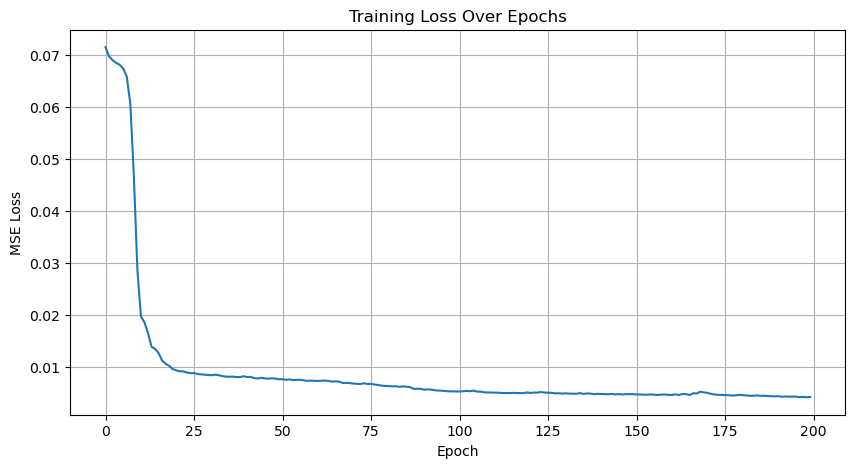


Extracting meta-features...
Meta-features extracted with shape: (150, 2)
Meta-features saved to iris_meta_features.csv as CSV
Model saved to iris_autoencoder_model.pth


In [16]:
# Plot loss history
print("\nPlotting loss history...")
plot_loss_history(loss_history)

# Extract meta-features
print("\nExtracting meta-features...")
meta_features = autoencoder.extract_meta_features(df)

# Save meta-features
meta_features_path = "iris_meta_features.csv"
autoencoder.save_meta_features(meta_features, meta_features_path)

# Save model
model_path = "iris_autoencoder_model.pth"
autoencoder.save_model(model_path)


Evaluating the model...
Reconstruction MSE: 0.004158


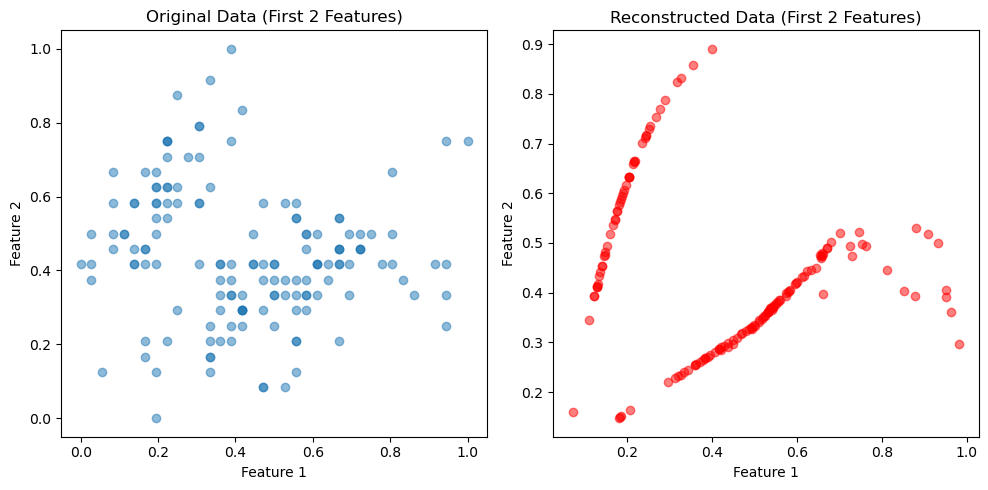


Visualizing the meta-features...


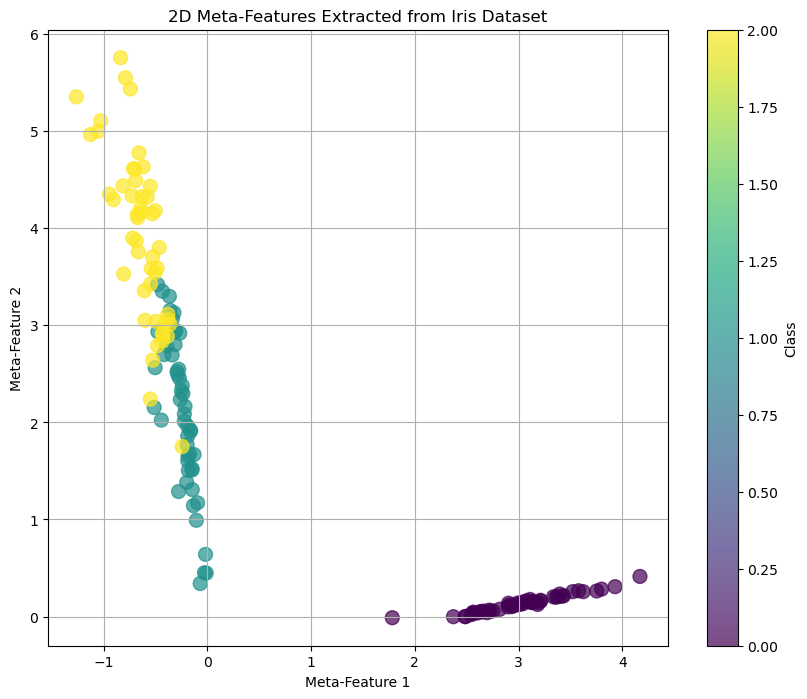


Example completed successfully!


In [17]:
# Evaluate model
print("\nEvaluating the model...")
mse = autoencoder.evaluate(df, plot=True)

# Visualize the meta-features
print("\nVisualizing the meta-features...")
y = iris.target
plt.figure(figsize=(10, 8))
plt.scatter(meta_features[:, 0], meta_features[:, 1], c=y, cmap='viridis', s=100, alpha=0.7)
plt.colorbar(label='Class')
plt.title("2D Meta-Features Extracted from Iris Dataset")
plt.xlabel("Meta-Feature 1")
plt.ylabel("Meta-Feature 2")
plt.grid(True)
plt.show()

print("\nExample completed successfully!")